# Modelos ARIMA

Los modelos ARIMA (Modelo de media móvil integrada autorregresiva o Autoregressive Integrated Moving Average). Pertenece a una clase de modelos que explican una serie de tiempo determinada en función de sus propios valores pasados, es decir, sus propios rezagos y los errores de pronóstico rezagados. La ecuación se puede utilizar para pronosticar valores futuros. Cualquier serie temporal "no estacional" que muestre patrones y no sea un ruido blanco aleatorio se puede modelar con modelos ARIMA.

Los modelos ARIMA se especifican mediante tres parámetros de orden: ($p, d, q$),

*   $AR(p)$ utiliza la relación dependiente entre una observación actual y las observaciones de un período anterior. El componente autorregresivo se refiere al uso de valores pasados ​​en la ecuación de regresión de la serie temporal.
*   $I(d)$: utiliza la diferenciación de observaciones para hacer que la serie de tiempo sea estacionaria. La diferenciación implica la resta de los valores actuales de una serie con sus valores anteriores un número determinado de veces. Por esta razón se dice que es el orden de integración.
*   $MA(q)$ es un modelo de media móvil que utiliza la dependencia entre una observación y un error residual de observaciones rezagadas. El componente de media móvil representa el error del modelo como una combinación de términos de error anteriores. El orden $q$ representa el número de términos que se incluirán en el modelo.

### Modelo $AR(p)$

\begin{equation}
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t
\end{equation}

Propiedades:

*   Es invertible por definición
*   Su función de autocorrelaciones decrece de forma exponencial
*   El orden $p$ del modelo viene determinado por la función de autocorrelaciones parciales


### Modelo $MA(q)$

\begin{equation}
Y_t = \epsilon_t - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \ldots - \theta_q \epsilon_{t-q}
\end{equation}

Propiedades:

*   Es estacionario por definición
*   El orden $q$ del modelo viene determinado por la función de autocorrelaciones

### Modelo $ARMA(p,q)$

\begin{equation}
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \ldots - \theta_q \epsilon_{t-q}
\end{equation}

Propiedades:

*   Las funciones de autocorrelaciones, de autocovarianzas y de autocorrelaciones parciales son infinitas

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.txt')

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


Dataset dimensions; (204, 2)
Training data dimension: (163, 2) 79.9 % of dataset
Test data dimension: (41, 2) 20.1 % of dataset


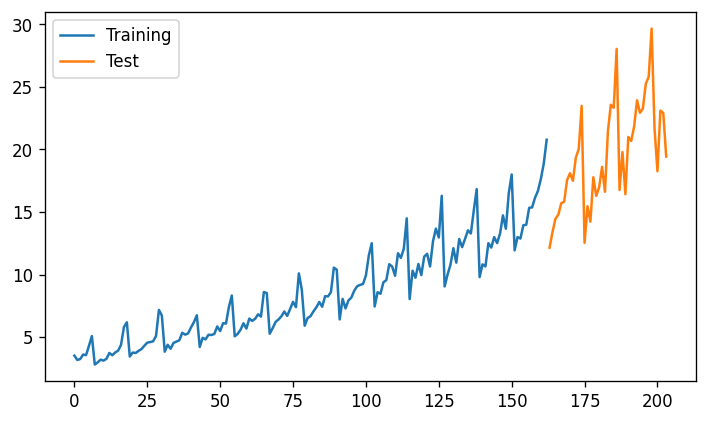

In [152]:
# Grafico la serie temporal y separo en conjuntos de entrenamiento y testeo 80:20

print('Dataset dimensions;', df.shape)
train_data = df[:-int(round(len(df)*0.2,0))]
test_data = df[-int(round(len(df)*0.2,0)):]
print('Training data dimension:', train_data.shape, round((len(train_data)/len(df)*100),2),'% of dataset')
print('Test data dimension:', test_data.shape, round((len(test_data)/len(df)*100),2),'% of dataset')

# Plot training & test data
plt.figure(figsize=(7,4))
plt.plot(train_data.index, train_data['value'], label="Training")
plt.plot(test_data.index, test_data['value'], label="Test")

plt.legend()
plt.show()

## Obtener el orden de integración $I(d)$

En el gráfico anterior se observa que la serie es no estacionaria en varianza y media. Se procede a aplicar la transformación Box-Cox para estabilizar la varianza. El orden de integración viene dado por la cantidad de veces que se diferencia la serie para que sea estacionaria.

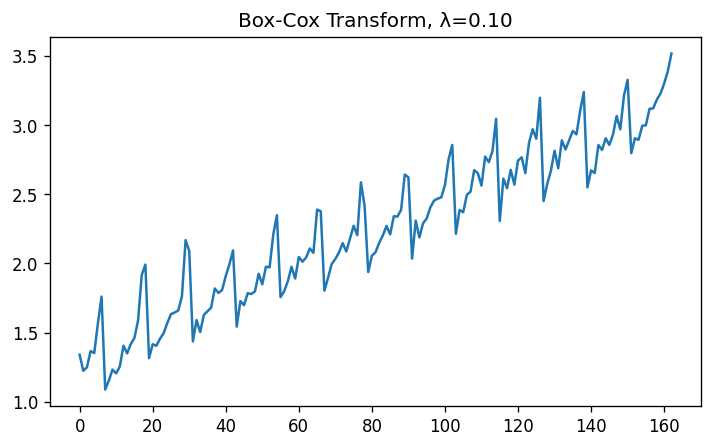

In [153]:
from scipy.stats import boxcox

data_stationarized = train_data.copy()
data_stationarized['value_box_cox'], lam = boxcox(data_stationarized['value'])

plt.figure(figsize=(7,4))
plt.plot(data_stationarized.index, data_stationarized['value_box_cox'])
plt.title(f'Box-Cox Transform, λ={lam:.2f}')
plt.show()

Para estabilizar la media se diferencia la serie

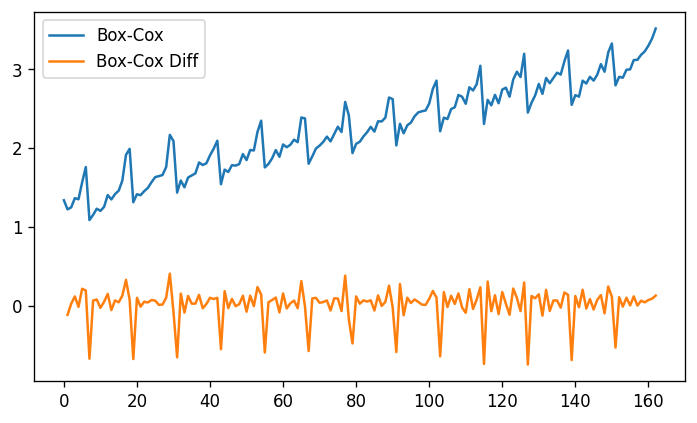

In [154]:
data_stationarized['value_box_cox_diff'] = data_stationarized['value_box_cox'].diff()

plt.figure(figsize=(7,4))
plt.plot(data_stationarized.index, data_stationarized['value_box_cox'], label="Box-Cox")
plt.plot(data_stationarized.index, data_stationarized['value_box_cox_diff'], label="Box-Cox Diff")

plt.legend()
plt.show()

La serie parece ser estacionaria. Podemos comprobarlo realizando el test ADF

In [155]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    #El criterio de información puede ser AIC O BIC
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

'''
Algunos parametros de la funcion adfuller:

x: The data series to test.

maxlag: Maximum lag which is included in test

regression: {“c”,”ct”,”ctt”,”n”} Constant and trend order to include in regression.
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.

autolag{“AIC”, “BIC”, “t-stat”, None} Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.
'''

adf_test(data_stationarized['value_box_cox_diff'][1:])

Results of Dickey-Fuller Test:
Test Statistic                  -3.721066
p-value                          0.003826
#Lags Used                      13.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


El p-value es menor al nivel de significación, por lo que se rechaza la hipótesis nula. La serie es estacionaria. El orden de integración es $d=1$ ya que tuvimos que diferenciar la serie una vez para que sea estacionaria

## Obtener el orden del término $AR(p)$

### Función de Autocorrelaciones parciales

El orden del modelo $AR(p)$ se obtiene mediante la función de autocorrelaciones parciales.

La función de autocorrelaciónes parciales (PACF) es la correlación entre la serie y su rezago, después de excluir las contribuciones de los rezagos intermedios. Entonces, PACF transmite la correlación pura o el grado de influencia entre un rezago y la serie (valor en $t$). De esta forma sabremos si ese desfase es necesario en el plazo del modelo AR.

Si la función de autocorrelaciones parciales no decrece exponencialmente, entonces se diferencia la serie para cumplir con la condición de estacionariedad. Se seleccionan aquellos rezagos que sean significativos.

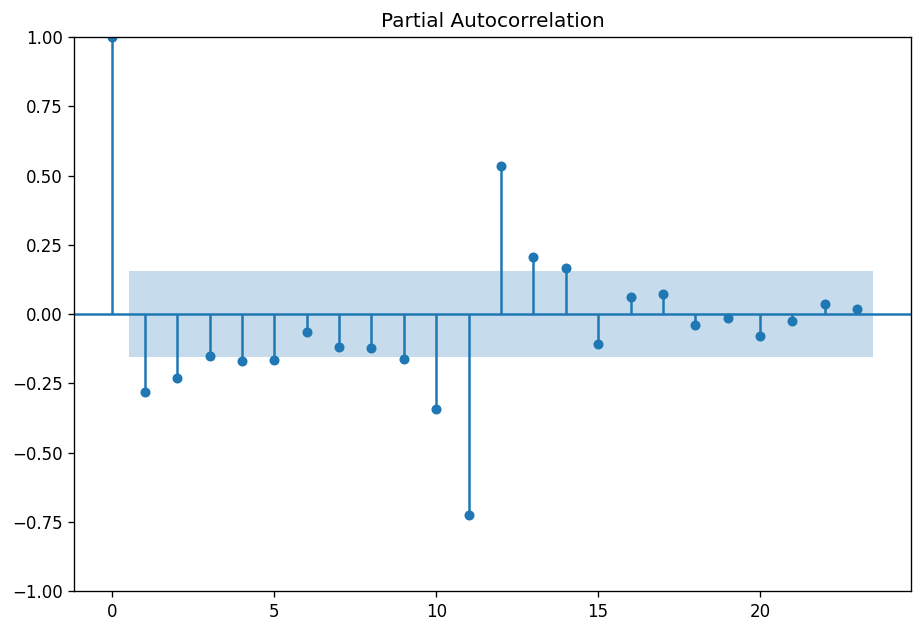

In [156]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(data_stationarized['value_box_cox_diff'][1:])

plt.show()

Hay una significatividad muy grande en la correlación del período 12, al ser datos mensuales podemos ver que hay estacionalidad anual. En cuanto a los rezagos mas recientes, los dos primeros rezagos son significativos por lo que $p=2$

## Obtener el orden del término $MA(q)$

### Función de Autocorrelaciones

El orden $q$ del modelo viene determinado por la función de autocorrelaciones (ACF). Esta función indica cuántos términos $MA$ se requieren para eliminar cualquier autocorrelación en la serie estacionaria

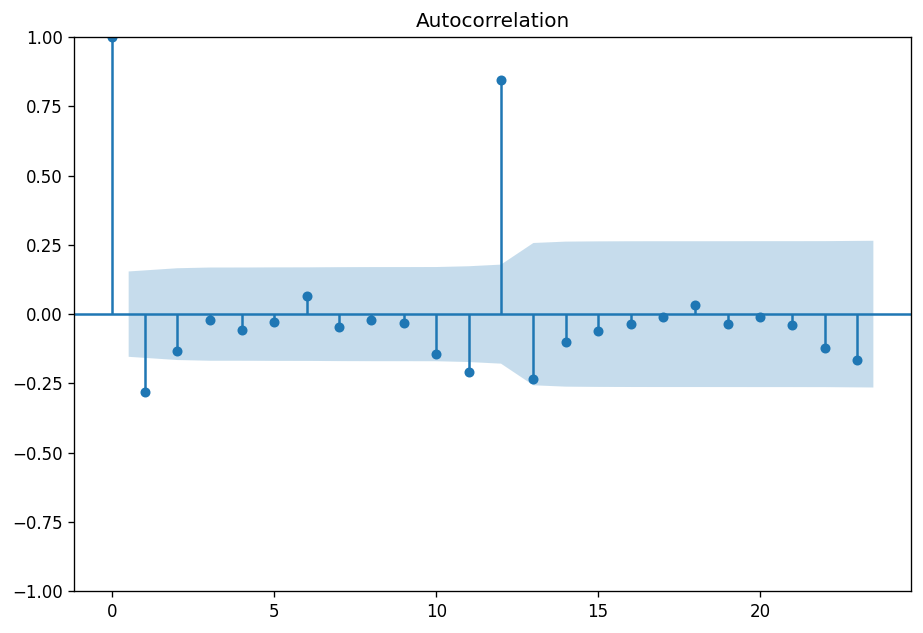

In [157]:
sm.graphics.tsa.plot_acf(data_stationarized['value_box_cox_diff'][1:])

plt.show()

Nuevamente se puede ver que en el rezago 12 hay una correlacion muy alta. Para los rezagos mas recientes, vemos que el primer rezago es significativo por lo que $q=1$

### Construcción del Modelo

In [158]:
model = sm.tsa.ARIMA(endog=train_data['value'], order=(2,1,1))
model_fit = model.fit()

### Evaluación de Resultados

In [159]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  163
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -288.230
Date:                Mon, 08 Jul 2024   AIC                            584.460
Time:                        22:25:52   BIC                            596.810
Sample:                             0   HQIC                           589.475
                                - 163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3326      0.278      1.194      0.232      -0.213       0.878
ar.L2          0.0075      0.150      0.050      0.960      -0.287       0.302
ma.L1         -0.8081      0.195     -4.153      0.000      -1.189      -0.427
sigma2         2.0487      0.187     10.939      0.000       1.682       2.416
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               118.90
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               5.45   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
from sklearn.metrics import mean_squared_error

y_pred = model_fit.forecast(steps=len(test_data))

# when squared=False then is equals to RMSE
mean_squared_error(y_true=test_data['value'], y_pred=y_pred, squared=False)

4.628462524760417

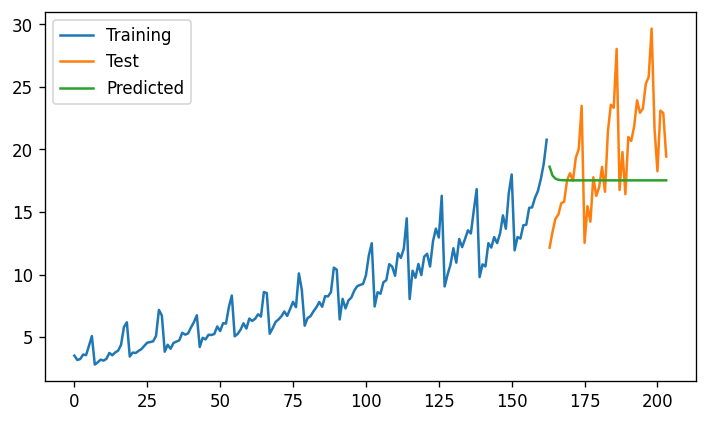

In [161]:
prediction = pd.DataFrame(y_pred, index=test_data.index)
prediction.columns = ['predicted_value']
prediction

# Plot prediction against test and training trends

plt.figure(figsize=(7,4))
plt.plot(train_data['value'], label="Training")
plt.plot(test_data['value'], label="Test")
plt.plot(prediction, label="Predicted")
plt.legend()

plt.show()

Es lógico que el modelo no funcione correctamente, ya que usamos un modelo ARIMA, sin incorporar que la serie de tiempo tiene estacionalidad anual. Para mejorar la predicción se puede generalizar este modelo y utilizar un modelo SARIMAX.

# SARIMAX

Se generaliza el modelo ARIMA agregándole terminos que permitan capturar la estacionalidad y terminos para capturar información sobre variables exógenas que permiten a entender y pronosticar la variable de interés

\begin{equation}
Y_t = c + \sum_{n=1}^{p} \phi_n Y_{t-n} + \sum_{n=1}^{q} \theta_n \epsilon_{t-n} + \sum_{n=1}^{r} {\beta_n x_{n_t}} + \sum_{n=1}^{P} \alpha_n Y_{t-sn} + \sum_{n=1}^{Q} \eta_n \epsilon_{t-sn} + \epsilon_t
\end{equation}

In [162]:
model = sm.tsa.SARIMAX(endog=train_data['value'], order=(2,1,1), seasonal_order=(2,1,1,12))
model_fit = model.fit()

## Evaluación de Resultados

In [163]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  163
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -115.943
Date:                            Mon, 08 Jul 2024   AIC                            245.886
Time:                                    22:31:52   BIC                            266.960
Sample:                                         0   HQIC                           254.448
                                            - 163                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3943      0.183     -2.153      0.031      -0.753      -0.035
ar.L2         -0.1443      0.153     -0.942      0.346      -0.445       0.156
ma.L1         -0.4799      0.180     -2.669      0.008      -0.832      -0.127
ar.S.L12       0.0504      0.310      0.163      0.871      -0.556       0.657
ar.S.L24      -0.1877      0.103     -1.822      0.068      -0.390       0.014
ma.S.L12      -0.2843      0.312     -0.910      0.363      -0.897       0.328
sigma2         0.2697      0.030      9.143      0.000       0.212       0.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.45
Prob(Q):                              0.96   Prob(JB):                         0.07
Heteroskedasticity (H):               3.25   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

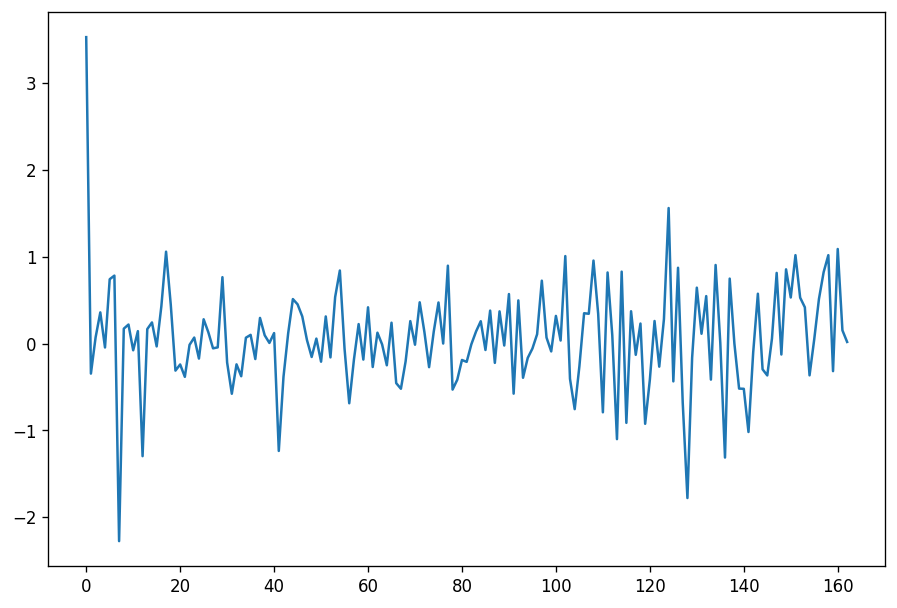

In [166]:
model_fit.resid.plot()

In [164]:
from sklearn.metrics import mean_squared_error

y_pred = model_fit.forecast(steps=len(test_data))

# when squared=False then is equals to RMSE
mean_squared_error(y_true=test_data['value'], y_pred=y_pred, squared=False)

2.0354529362177383

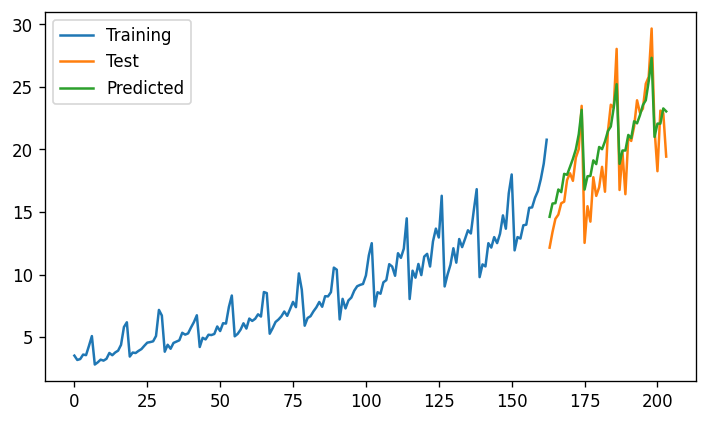

In [165]:
prediction = pd.DataFrame(y_pred, index=test_data.index)
prediction.columns = ['predicted_value']
prediction

# Plot prediction against test and training trends

plt.figure(figsize=(7,4))
plt.plot(train_data['value'], label="Training")
plt.plot(test_data['value'], label="Test")
plt.plot(prediction, label="Predicted")
plt.legend()

plt.show()